In [140]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.utils import shuffle
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
import scipy
from lime import lime_tabular

In [86]:
fake = pd.read_csv("Fake.csv")
true = pd.read_csv("True.csv")

In [87]:
fake['target'] = 'fake'
true['target'] = 'true'
data = pd.concat([fake, true]).reset_index(drop = True)
#data = shuffle(data)
#print(data)
#data=data.iloc[:5]
data.shape
#print(data)
#print(type(data))
data.head()


,title,text,subject,date,target
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",fake
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",fake
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",fake
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",fake
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",fake


In [88]:
data.drop(["date"],axis=1,inplace=True)
data.head()
data.drop(["title"],axis=1,inplace=True)
data.head()
data['text'] = data['text'].apply(lambda x: x.lower())
data.head()

,text,subject,target
0,donald trump just couldn t wish all americans ...,News,fake
1,house intelligence committee chairman devin nu...,News,fake
2,"on friday, it was revealed that former milwauk...",News,fake
3,"on christmas day, donald trump announced that ...",News,fake
4,pope francis used his annual christmas day mes...,News,fake


In [89]:
import string

def punctuation_removal(text):
    all_list = [char for char in text if char not in string.punctuation]
    clean_str = ''.join(all_list)
    return clean_str

data['text'] = data['text'].apply(punctuation_removal)
data.head()

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')

data['text'] = data['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

[nltk_data] Downloading package stopwords to /Users/evan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [96]:
print(type(data))
d=data.iloc[0:10][:]
e=data.iloc[44888:44896][:]
print(type(e))
print(type(e))
print('d = ',d)
print('e = ',e)
data2=pd.concat([d,e], axis=0)



<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
d =                                                  text subject target
0  donald trump wish americans happy new year lea...    News   fake
1  house intelligence committee chairman devin nu...    News   fake
2  friday revealed former milwaukee sheriff david...    News   fake
3  christmas day donald trump announced would bac...    News   fake
4  pope francis used annual christmas day message...    News   fake
5  number cases cops brutalizing killing people c...    News   fake
6  donald trump spent good portion day golf club ...    News   fake
7  wake yet another court decision derailed donal...    News   fake
8  many people raised alarm regarding fact donald...    News   fake
9  might thought get break watching people kiss d...    News   fake
e =                                                      text    subject target
44888  sao paulo reuters cesar mata pires owner cofou

subject
Government News     1570
Middle-east          778
News                9050
US_News              783
left-news           4459
politics            6841
politicsNews       11272
worldnews          10145
Name: text, dtype: int64


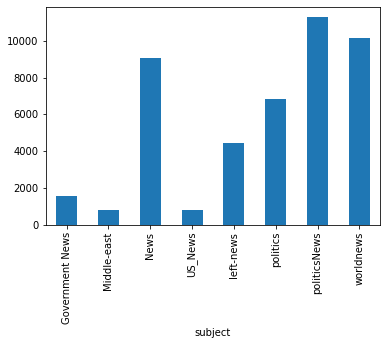

In [97]:
print(data.groupby(['subject'])['text'].count())
data.groupby(['subject'])['text'].count().plot(kind="bar")
plt.show()

In [102]:
X_train,X_test,y_train,y_test = train_test_split(data2['text'],data2.target,test_size=0.2,random_state=42)
print('X_train = ',X_train,'y_train = ',y_train,'X_test = ',X_test,'y_test = ',y_test)
print('xtrain shape = ',X_train.shape)
print('ytrain shape = ',y_train.shape)
print('x_test shape = ',X_test.shape)
print('y_test shape = ',y_test.shape)


X_train =  3        christmas day donald trump announced would bac...
44891    copenhagen reuters danish police said tuesday ...
44894    london reuters lexisnexis provider legal regul...
44893    brussels reuters nato allies tuesday welcomed ...
44889    geneva reuters north korea united states clash...
2        friday revealed former milwaukee sheriff david...
9        might thought get break watching people kiss d...
44895    minsk reuters shadow disused sovietera factori...
4        pope francis used annual christmas day message...
44890    geneva reuters north korea united states accus...
7        wake yet another court decision derailed donal...
44888    sao paulo reuters cesar mata pires owner cofou...
44892    united nations reuters two north korean shipme...
6        donald trump spent good portion day golf club ...
Name: text, dtype: object y_train =  3        fake
44891    true
44894    true
44893    true
44889    true
2        fake
9        fake
44895    true
4        fake


In [106]:
X_t=pd.concat([X_train,X_test])
print('X_t = ',X_t.shape)
ltotal=len(X_t)
print(X_t)

X_t =  (18,)
3        christmas day donald trump announced would bac...
44891    copenhagen reuters danish police said tuesday ...
44894    london reuters lexisnexis provider legal regul...
44893    brussels reuters nato allies tuesday welcomed ...
44889    geneva reuters north korea united states clash...
2        friday revealed former milwaukee sheriff david...
9        might thought get break watching people kiss d...
44895    minsk reuters shadow disused sovietera factori...
4        pope francis used annual christmas day message...
44890    geneva reuters north korea united states accus...
7        wake yet another court decision derailed donal...
44888    sao paulo reuters cesar mata pires owner cofou...
44892    united nations reuters two north korean shipme...
6        donald trump spent good portion day golf club ...
0        donald trump wish americans happy new year lea...
1        house intelligence committee chairman devin nu...
8        many people raised alarm regarding

In [124]:

vectorizer = TfidfVectorizer(lowercase=False)
v = vectorizer.fit_transform(X_t)
features=vectorizer.get_feature_names_out()
ltrain=len(X_train)
vtrain=v[0:ltrain][:]
vtest=v[ltrain:][:]
vtrain=scipy.sparse.csr_matrix.toarray(vtrain)
vtest=scipy.sparse.csr_matrix.toarray(vtest)
print(type(vtest))
print(vtest)


<class 'numpy.ndarray'>
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.11909989 0.         0.        ]]


In [205]:
mo=LogisticRegression()
mo.fit(vtrain,y_train)
m=mo.predict(vtest)
m=np.array(m)
y_test=np.array(y_test)
print(y_test)
print(m)

print("accuracy: {}%".format(round(accuracy_score(y_test, m)*100,2)))

['fake' 'fake' 'fake' 'fake']
['true' 'true' 'true' 'true']
accuracy: 0.0%


In [215]:
def p(news):
    v3=vectorizer.transform(news)
    print('v3 = ',v3)
    print('fonction p lancée')
    r3=mo.predict([v3])
    print('r3 = ',r3)
    return(r3)


#xk=p(['test'])
#print(xk)
x=p(X_train[2].split(" "))
#print(X_train[2])
print(np.shape(x))
#print((X_train[2].split(" ")))

#explainer = lime_tabular.LimeTabularExplainer(vtrain,mode="regression")
#explainer.explain_instance(data_row=X_train[2].split(" "),predict_fn=p, labels=features)

v3 =    (0, 799)	1.0
  (1, 1609)	1.0
  (2, 779)	1.0
  (3, 1207)	1.0
  (4, 1700)	1.0
  (5, 493)	1.0
  (6, 378)	1.0
  (7, 428)	1.0
  (8, 910)	1.0
  (9, 1672)	1.0
  (10, 1669)	1.0
  (11, 602)	1.0
  (12, 1927)	1.0
  (13, 94)	1.0
  (14, 638)	1.0
  (15, 1657)	1.0
  (16, 1338)	1.0
  (17, 1014)	1.0
  (18, 293)	1.0
  (19, 1636)	1.0
  (20, 1396)	1.0
  (21, 378)	1.0
  (22, 741)	1.0
  (23, 1357)	1.0
  (24, 484)	1.0
  :	:
  (314, 1621)	1.0
  (315, 505)	1.0
  (316, 54)	1.0
  (317, 38)	1.0
  (318, 1879)	1.0
  (319, 58)	1.0
  (320, 267)	1.0
  (321, 1158)	1.0
  (322, 567)	1.0
  (323, 1877)	1.0
  (324, 378)	1.0
  (325, 1207)	1.0
  (326, 461)	1.0
  (327, 1012)	1.0
  (328, 340)	1.0
  (329, 168)	1.0
  (330, 1984)	1.0
  (331, 913)	1.0
  (332, 1882)	1.0
  (333, 1409)	1.0
  (334, 1572)	1.0
  (335, 648)	1.0
  (336, 1746)	1.0
  (337, 1400)	1.0
  (338, 942)	1.0
fonction p lancée


ValueError: Expected 2D array, got 1D array instead:
array=[<339x2085 sparse matrix of type '<class 'numpy.float64'>'
 	with 339 stored elements in Compressed Sparse Row format>].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.